In [2]:
import os
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import seaborn as sns


In [3]:
# For the bio dataset
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"

# For the hydro dataset
base_url2 = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"

In [4]:
month_st = 1   # Starting month 
# month_ed = 1   # Ending month 
year = 2016    # Year

# Based on the server the file naming convention 
# biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
# hydrofiles = [f"{base_url2}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
netCDF_datestr = str(year)+'-'+format(month_st, '02')
biofiles = base_url+netCDF_datestr+".nc"
hydrofiles = base_url2+netCDF_datestr+".nc"

# Reading the file on the server
nc_data_bio = Dataset(biofiles, 'r')
nc_data_hydro = Dataset(hydrofiles, 'r')
print('Get the list of variable in the file:')
print(list(nc_data_bio.variables.keys()))
print(list(nc_data_hydro.variables.keys()))

# Get the lat and lon
lat = nc_data_hydro['latitude'][:]
lon = nc_data_hydro['longitude'][:]
print('\neReefs model spatial extent:')
print(' - Longitudinal extent:',lon.min(),lon.max())
print(' - Latitudinal extent:',lat.min(),lat.max(),'\n')

# Get the zc data
zc = nc_data_hydro['zc'][:]
nlay = len(zc)
for k in range(nlay):
    print(f'  + vertical layer {k} is at {zc[k]} m')

Get the list of variable in the file:
['TOTAL_NITROGEN', 'alk', 'BOD', 'Chl_a_sum', 'CO32', 'DetBL_N', 'DetPL_N', 'DetR_N', 'DIC', 'DIN', 'DIP', 'DOR_C', 'DOR_N', 'DOR_P', 'Dust', 'EFI', 'FineSed', 'Fluorescence', 'HCO3', 'Kd_490', 'MPB_Chl', 'MPB_N', 'MPB_NR', 'Mud-carbonate', 'Mud-mineral', 'Nfix', 'NH4', 'NO3', 'omega_ar', 'Oxy_sat', 'Oxygen', 'P_Prod', 'PAR', 'PAR_z', 'pco2surf', 'PH', 'PhyL_Chl', 'PhyL_N', 'PhyL_NR', 'PhyS_Chl', 'PhyS_N', 'PhyS_NR', 'PIP', 'salt', 'TC', 'temp', 'TN', 'TP', 'Tricho_Chl', 'Tricho_N', 'Tricho_NR', 'Z_grazing', 'ZooL_N', 'ZooS_N', 'zc', 'time', 'latitude', 'longitude', 'CH_N', 'CS_bleach', 'CS_Chl', 'CS_N', 'EpiPAR_sg', 'eta', 'MA_N', 'MA_N_pr', 'month_EpiPAR_sg', 'R_400', 'R_410', 'R_412', 'R_443', 'R_470', 'R_486', 'R_488', 'R_490', 'R_510', 'R_531', 'R_547', 'R_551', 'R_555', 'R_560', 'R_590', 'R_620', 'R_640', 'R_645', 'R_665', 'R_667', 'R_671', 'R_673', 'R_678', 'R_681', 'R_709', 'R_745', 'R_748', 'R_754', 'R_761', 'R_764', 'R_767', 'R_778', 'Sec

Show the area that we are focusing on

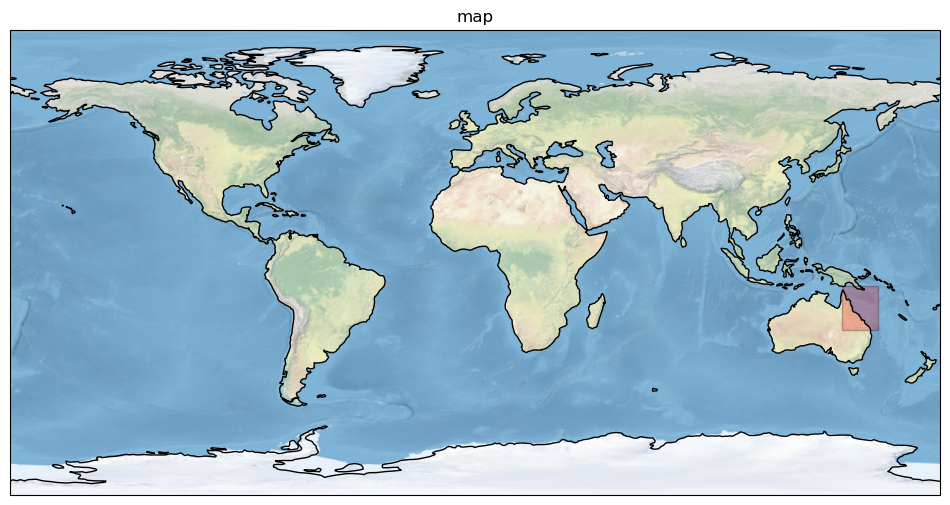

In [5]:
#extent = [np.min(ds.longitude),np.max(ds.longitude),np.min(ds.latitude),np.max(ds.latitude)]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

fig0 = plt.figure(figsize=(12,12))
central_lon = 150 #TODO
ax0 = fig0.add_subplot(111,projection=ccrs.PlateCarree())
ax0.stock_img()
ax0.coastlines()
ax0.set_title('map')
ax0.add_patch(mpatches.Rectangle(xy=[142, -26], width=14, height=17, #TODO
                                    facecolor='red',
                                    edgecolor='k',
                                    alpha=0.25,
                                    transform=ccrs.PlateCarree()))
plt.show()


Line graph for 2016

In [6]:
biofiles_timeseries2 = []
hydrofiles_timeseries2 = []

#TODO include more dates
start_date = dt.date(2016, 1, 1)
end_date = dt.date(2016, 3, 15)

current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    
    # Construct the filenames for each month and year
    biofiles_timeseries2.append(f"{base_url}{year}-{month:02}.nc")
    hydrofiles_timeseries2.append(f"{base_url2}{year}-{month:02}.nc")
    
    # Move to the next month
    current_date += relativedelta(months=1)

selectedDepthIndex = -1 # corresponding to -0.5 m for GBR4

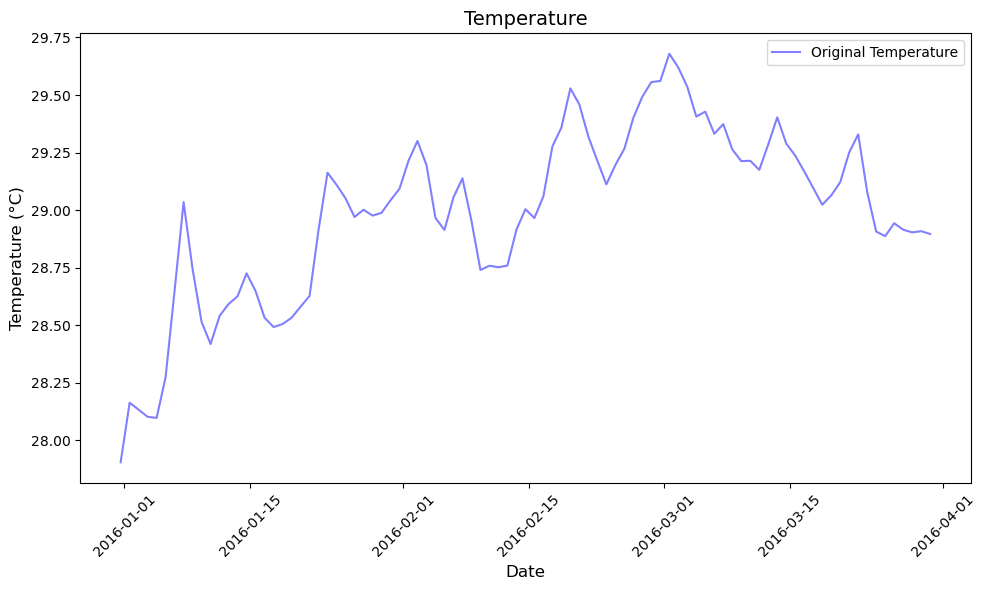

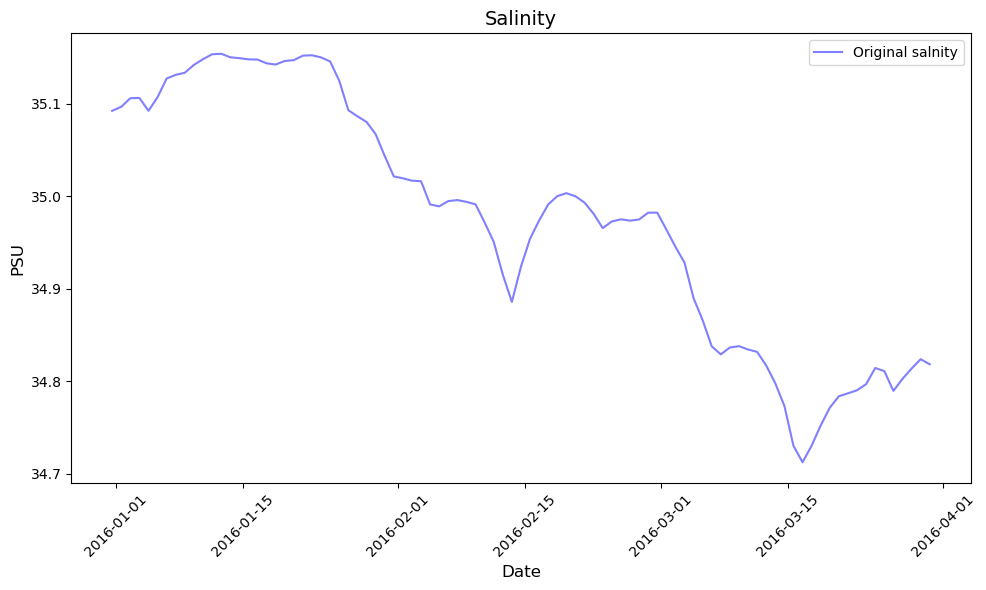

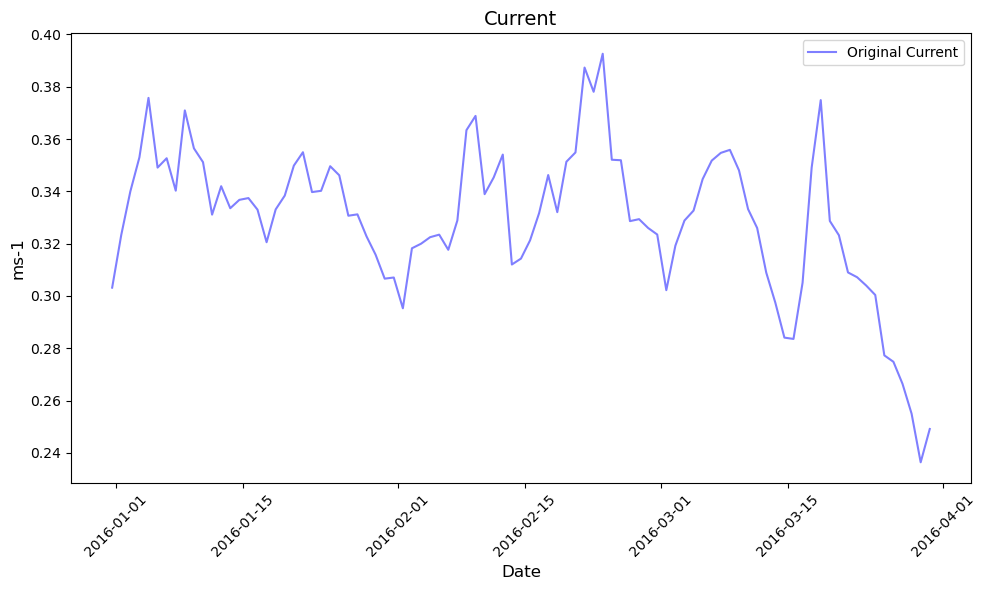

In [7]:
# Load datasets using xarray
ds_bio = xr.open_mfdataset(biofiles_timeseries2[:], chunks={'time': '100MB'}) # end is 44
# ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[:56], chunks={'time': '100MB'}) #56 is the end
ds_hydro = xr.open_mfdataset(hydrofiles_timeseries2[:], chunks={'time': '100MB'})
# Extract and select nearest values based on latitude and longitude
ph = ds_bio.PH.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])
temperature = ds_hydro.temp.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])
salinity = ds_hydro.salt.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])
mean_cur = ds_hydro.mean_cur.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])

df3 = pd.DataFrame({
    'date': pd.to_datetime(temperature.time.values),
    'pH': ph.values,
    'current': mean_cur.values,
    'temperature': temperature.values,
    'salinity': salinity.values
})
df3.to_csv("Documents/GitHub/ENVI5809_Grp4/2016hydro.csv", sep=" ", index=False)

# Plotting the temperature
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original temperature data
ax.plot(df3['date'], df3['temperature'], label='Original Temperature', color='blue', alpha=0.5)


# Set title and labels
ax.set_title("Temperature", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



# Plotting the salinity
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original salinity data
ax.plot(df3['date'], df3['salinity'], label='Original salnity', color='blue', alpha=0.5)

# Set title and labels
ax.set_title("Salinity", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("PSU", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



# Plotting the current
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original current data
ax.plot(df3['date'], df3['current'], label='Original Current', color='blue', alpha=0.5)

# Set title and labels
ax.set_title("Current", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("ms-1", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (optional, if you have many columns)

# Now print the DataFrame
#print(df3)

In [9]:
def eReefs_map(nc_data_hydro, tstep, depth, dataname, datalvl, color, size, 
               fname, vecsample, veclenght, vecscale, zoom=None, 
               show=False, vecPlot=False, save=False):
            # Get data
    data = nc_data_hydro[dataname][tstep, depth, :,:]
    
    fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())
    
    # Starting with the spatial domain
    lat = nc_data_hydro['latitude'][:]
    lon = nc_data_hydro['longitude'][:]
    cf = plt.pcolormesh(lon, lat, data, cmap=color, shading='auto',
                    vmin = datalvl[0], vmax = datalvl[1],
                    transform=ccrs.PlateCarree())
                    # Plot velocity arrows 
    if vecPlot:
        loni, lati = np.meshgrid(lon, lat)
        u = nc_data_hydro['u'][tstep, depth, :,:]
        v = nc_data_hydro['v'][tstep, depth, :,:]
                
        if zoom is not None:
            # find non zeros velocity points
            dataid = np.where(np.logical_and(data.flatten()>datalvl[0],
                                          data.flatten()<datalvl[1]))[0]
            
            lonid = np.where(np.logical_and(loni.flatten()>zoom[0],
                                          loni.flatten()<zoom[2]))[0]
            
            latid = np.where(np.logical_and(lati.flatten()>zoom[1],
                                          lati.flatten()<zoom[3]))[0]
            
            tmpid = np.intersect1d(lonid, latid)
            ind = np.intersect1d(tmpid, dataid)
        else:
            # find non zeros velocity points
            ind = np.where(np.logical_and(data.flatten()>datalvl[0],
                                          data.flatten()<datalvl[1]))[0]
        np.random.shuffle(ind)
        Nvec = int(len(ind) / vecsample)
        idv = ind[:Nvec]
        Q = plt.quiver(loni.flatten()[idv],
                       lati.flatten()[idv],
                       u.flatten()[idv],
                       v.flatten()[idv],
                       transform=ccrs.PlateCarree(), 
                       scale=vecscale)
        maxstr='%3.1f m/s' % veclenght
        qk = plt.quiverkey(Q,0.1,0.1,veclenght,maxstr,labelpos='S')


    # Color bar
    cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                        orientation="horizontal")
    cbar.set_label(nc_data_hydro[dataname].units, rotation=0, 
                   labelpad=5, fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    

    # Title
    dtime = netCDF4.num2date(nc_data_hydro['time'][tstep],nc_data_hydro['time'].units)
    daystr = dtime.strftime('%Y-%b-%d %H:%M')
    plt.title(nc_data_hydro[dataname].long_name+', %s UTC+10' % (daystr), 
              fontsize=11);

    # Plot lat/lon grid 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.1, color='k', alpha=1, 
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8} 
    
    # Add map features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='lightgray'))
    ax.coastlines(linewidth=1)

    if zoom is not None:
        plt.xlim(zoom[0],zoom[2])
        plt.ylim(zoom[1],zoom[3])
    
    if show:
        if save:
            plt.savefig(f"{fname}_time{tstep:04}_zc{depth:04}.png",dpi=300, 
                    bbox_inches='tight')
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(f"{fname}_time{tstep:04}_zc{depth:04}.png",dpi=300, 
                bbox_inches='tight')

    fig.clear()
    plt.close(fig)
    plt.clf()
    
    return

# Vector field mapping information
veclenght = 1.
vecsample = 50
vecscale = 20

# Figure size
size = (9, 10)

# Used color
color = cmocean.cm.thermal

# Variable range for the colorscale
curlvl = [24,29]

# Saved file name
fname = 'GBRtemp'+str(k)

# Region to plot
zoom = None

In [10]:
## PH Graphs
selectedTimeIndex = 2    # we have 29 time records jan2
print('PH range: ')
print(np.nanmin(nc_data_bio['PH'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_bio['PH'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nTemperature range: ')
print(np.nanmin(nc_data_hydro['temp'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro['temp'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nSalinity range: ')
print(np.nanmin(nc_data_hydro['salt'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro['salt'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nCurrent range: ')
print(np.nanmin(nc_data_hydro['mean_cur'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro['mean_cur'][selectedTimeIndex, selectedDepthIndex, :,:]))

PH range: 
6.462294 8.210004

Temperature range: 
24.086714 34.30648

Salinity range: 
0.035477985 36.949455

Current range: 
0.010849479 1.3686506


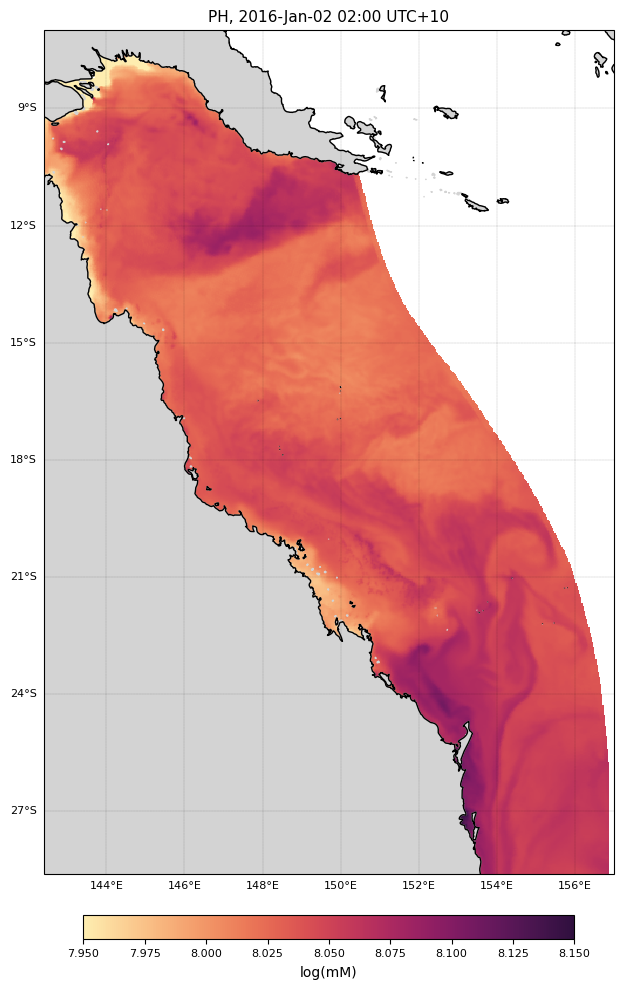

<Figure size 640x480 with 0 Axes>

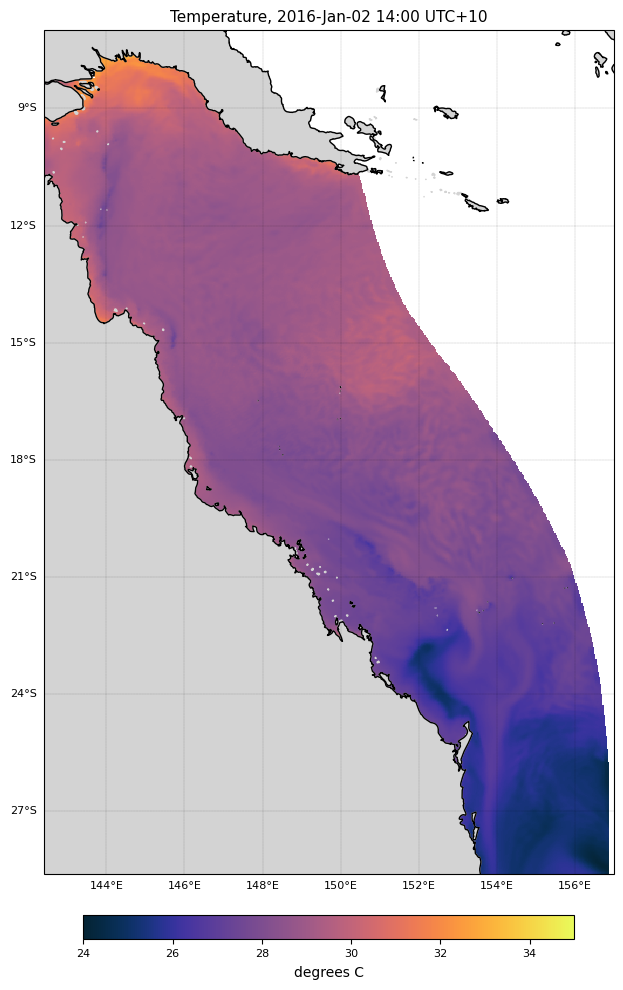

<Figure size 640x480 with 0 Axes>

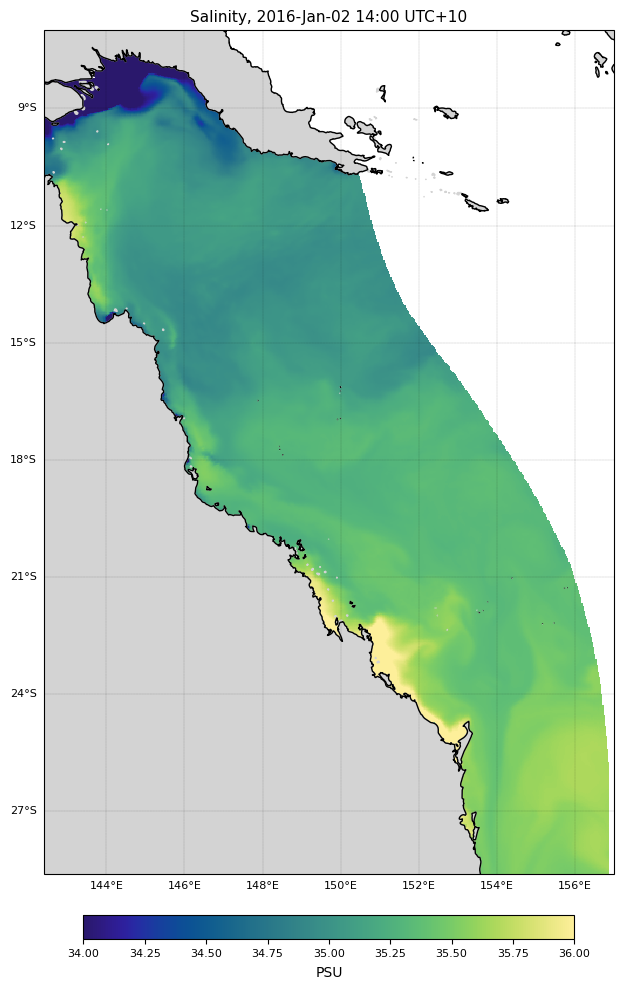

<Figure size 640x480 with 0 Axes>

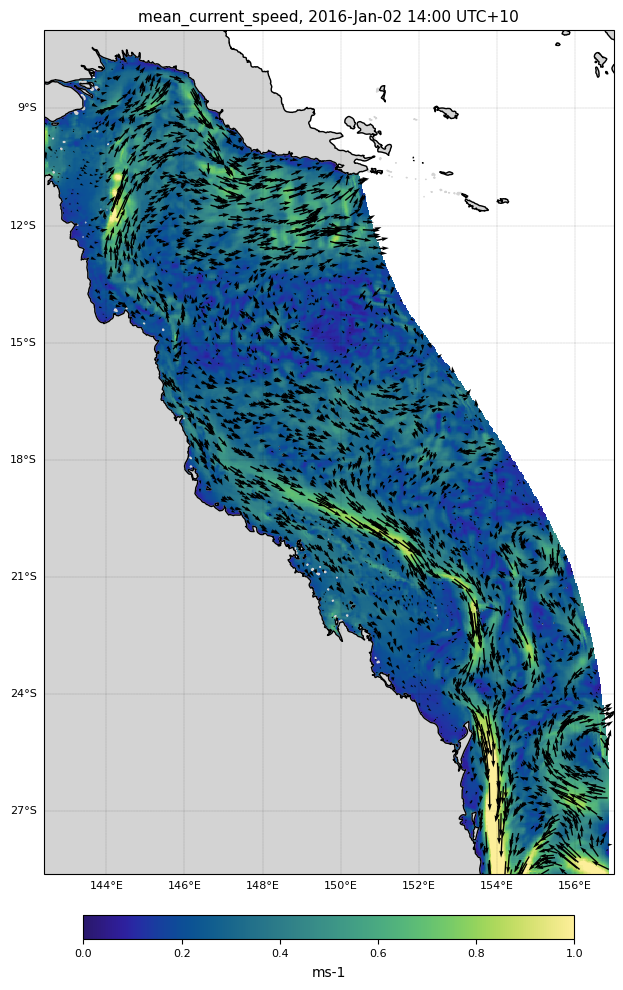

<Figure size 640x480 with 0 Axes>

In [11]:
# PH map
# Used color
color = cmocean.cm.matter

# Variable range for the colorscale
templvl = [7.95,8.15]

# Saved file name
fname = 'GBRpH'

# We now call the function
eReefs_map(nc_data_bio, selectedTimeIndex-1, selectedDepthIndex, 
           'PH', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=False, save=False)



# Temperature map
# Used color
color = cmocean.cm.thermal

# Variable range for the colorscale
templvl = [24,35]

# Saved file name
fname = 'GBRtemperature'

# We now call the function
eReefs_map(nc_data_hydro, selectedTimeIndex, selectedDepthIndex, 
           'temp', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=False, save=False)


#Salinity map
# Used color
color = cmocean.cm.haline

# Variable range for the colorscale
templvl = [34,36]

# Saved file name
fname = 'GBRsalinity'

# We now call the function
eReefs_map(nc_data_hydro, selectedTimeIndex, selectedDepthIndex, 
           'salt', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=False, save=False)


# Current Map
# Used color
color = cmocean.cm.haline

# Variable range for the colorscale
templvl = [0,1]

# Saved file name
fname = 'GBRcurrent'

# We now call the function
eReefs_map(nc_data_hydro, selectedTimeIndex, selectedDepthIndex, 
           'mean_cur', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=True, save=False)

Heron Reefs

In [12]:
# Heron Reefs position
# TODO
min_lon = 151    # lower left longitude
min_lat = -24     # lower left latitude
max_lon = 153     # upper right longitude
max_lat = -22.35     # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]
selectedDepthIndex = -1 # corresponding to -0.5 m for GBR4

In [13]:
biofiles_timeseries = []
hydrofiles_timeseries = []

#TODO include more dates
start_date = dt.date(2011, 1, 1)
end_date = dt.date(2018, 12, 31)

current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    
    # Construct the filenames for each month and year
    biofiles_timeseries.append(f"{base_url}{year}-{month:02}.nc")
    hydrofiles_timeseries.append(f"{base_url2}{year}-{month:02}.nc")
    
    # Move to the next month
    current_date += relativedelta(months=1)

In [14]:
# hydrofiles_timeseries


In [15]:
# biofiles_timeseries[50]

In [16]:

ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[55:56], chunks={'time': '100MB'})

In [17]:
# Load datasets using xarray
# ds_bio = xr.open_mfdataset(biofiles_timeseries[:44], chunks={'time': '100MB'})
# ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[:56], chunks={'time': '100MB'}) #56 is the end
#TODO adjust the list to include more years
ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[:], chunks={'time': '100MB'})
# Extract and select nearest values based on latitude and longitude
temperature = ds_hydro.temp.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
salinity = ds_hydro.salt.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
mean_cur = ds_hydro.mean_cur.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))

# mean_cur_rolling_flat = mean_cur_rolling.values
# temperature_rolling_flat = temperature_rolling.values

# Load data
time_index = pd.to_datetime(temperature.time.values)
load_temp = temperature.load(chunks={'time': '100MB'})
load_sal = salinity.load(chunks={'time': '100MB'})
load_curr = mean_cur.load(chunks={'time': '100MB'})

In [18]:
temperature_heatmap = load_temp.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])
salinity_heatmap = load_sal.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])
current_heatmap = load_curr.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])

# Create DataFrames for heatmaps
temp_df = pd.DataFrame(temperature_heatmap.values, index=time_index, columns=["Temperature (°C)"])
salinity_df = pd.DataFrame(salinity_heatmap.values, index=time_index, columns=["Salinity (PSU)"])
current_df = pd.DataFrame(current_heatmap.values, index=time_index, columns=["Current (m/s)"])

# Adding day, month, and year columns for pivoting
temp_df['day'] = temp_df.index.day
temp_df['month'] = temp_df.index.month
temp_df['year'] = temp_df.index.year

salinity_df['day'] = salinity_df.index.day
salinity_df['month'] = salinity_df.index.month
salinity_df['year'] = salinity_df.index.year

current_df['day'] = current_df.index.day
current_df['month'] = current_df.index.month
current_df['year'] = current_df.index.year

In [19]:
# df.head(200)

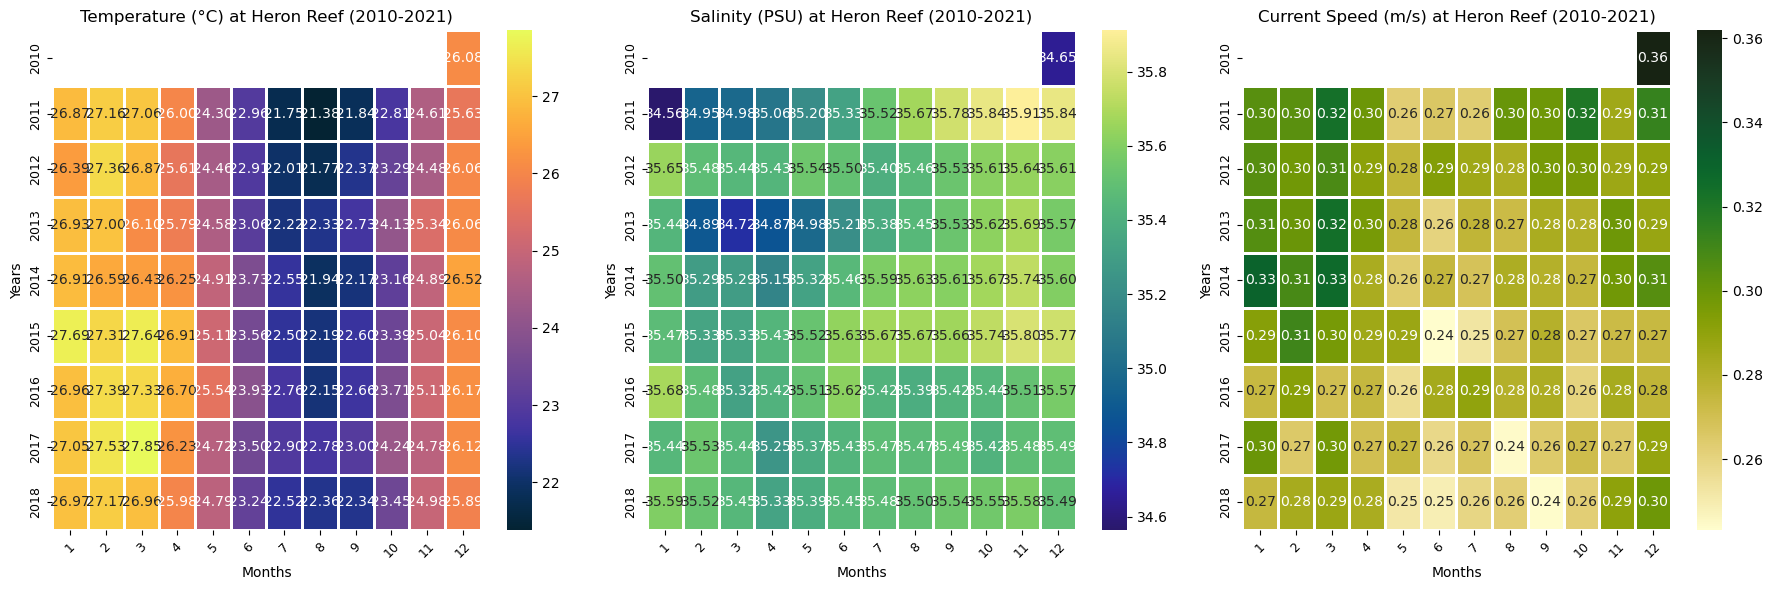

In [20]:
# Pivot the data to have months as columns and years as rows for heatmap
# Current_season = df.pivot_table(index="year", columns="month", values="current")
Temp_season = temp_df.pivot_table(index="year", columns="month", values="Temperature (°C)")
Salinity_season = salinity_df.pivot_table(index="year", columns="month", values="Salinity (PSU)")
Current_season = current_df.pivot_table(index="year", columns="month", values="Current (m/s)")

# Plotting Heatmaps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # side by side

# Temperature (Degrees C)
color = cmocean.cm.thermal
sns.heatmap(
    Temp_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=True, ax=axs[0]
)
axs[0].set_title("Temperature (°C) at Heron Reef (2010-2021)", fontsize=12)
axs[0].set_ylabel("Years", fontsize=10)
axs[0].set_xlabel("Months", fontsize=10)
axs[0].yaxis.set_tick_params(labelsize=9)
axs[0].xaxis.set_tick_params(labelsize=9, rotation=45)

# Salinity (PSU)
color = cmocean.cm.haline
sns.heatmap(
    Salinity_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=True, ax=axs[1]
)
axs[1].set_title("Salinity (PSU) at Heron Reef (2010-2021)", fontsize=12)
axs[1].set_ylabel("Years", fontsize=10)
axs[1].set_xlabel("Months", fontsize=10)
axs[1].yaxis.set_tick_params(labelsize=9)
axs[1].xaxis.set_tick_params(labelsize=9, rotation=45)

# Current (Speed)
color = cmocean.cm.speed
sns.heatmap(
    Current_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=True, ax=axs[2]
)
axs[2].set_title("Current Speed (m/s) at Heron Reef (2010-2021)", fontsize=12)
axs[2].set_ylabel("Years", fontsize=10)
axs[2].set_xlabel("Months", fontsize=10)
axs[2].yaxis.set_tick_params(labelsize=9)
axs[2].xaxis.set_tick_params(labelsize=9, rotation=45)

# Plot
plt.tight_layout()
plt.show()

Another rolling window

In [28]:
# TODO check if wanna do rolling, show trend in line graph
temperature_rolling = temperature_heatmap.rolling(time=180, center=True).mean()
df2 = pd.DataFrame({
    'date': pd.to_datetime(temperature.time.values),
    # 'lat': temperature.latitude.values,
    # 'lon': temperature.longitude.values,
    'temperature': temperature_heatmap.values,
    'temperatureRolling': temperature_rolling.values
})

In [29]:
df2['temperatureRolling']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN
30            NaN
31            NaN
32            NaN
33            NaN
34            NaN
35            NaN
36            NaN
37            NaN
38            NaN
39            NaN
40            NaN
41            NaN
42            NaN
43            NaN
44            NaN
45            NaN
46            NaN
47            NaN
48            NaN
49            NaN
50            NaN
51            NaN
52            NaN
53            NaN
54            NaN
55        

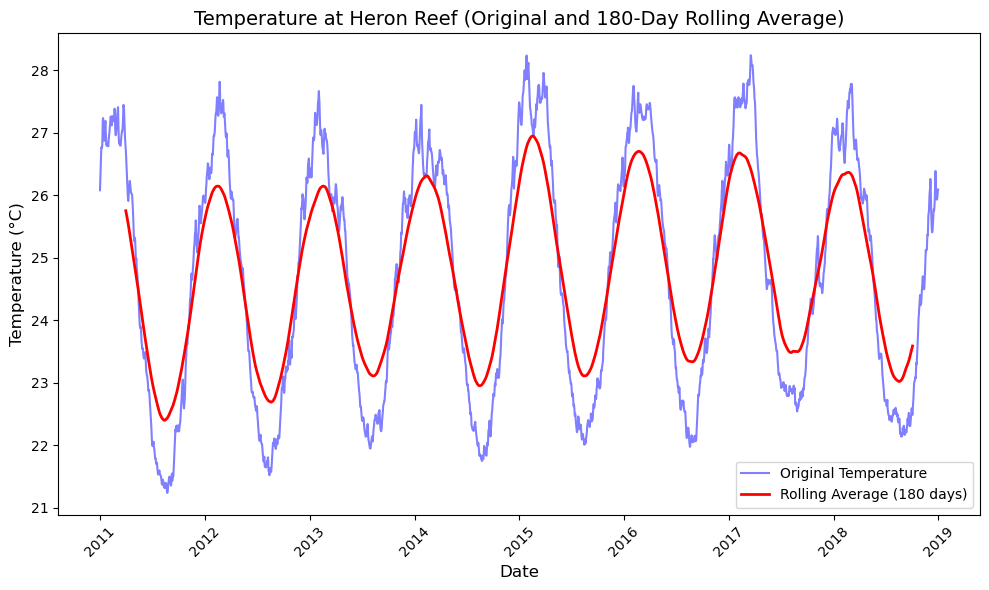

In [30]:
######################################

# Create line graph for temperature and rolling temperature

# Plotting the temperature and rolling temperature over time
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original temperature data
ax.plot(df2['date'], df2['temperature'], label='Original Temperature', color='blue', alpha=0.5)

# Plot rolling average temperature data
ax.plot(df2['date'], df2['temperatureRolling'], label='Rolling Average (180 days)', color='red', linewidth=2)

# Set title and labels
ax.set_title("Temperature at Heron Reef (Original and 180-Day Rolling Average)", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend to distinguish between original and rolling average
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

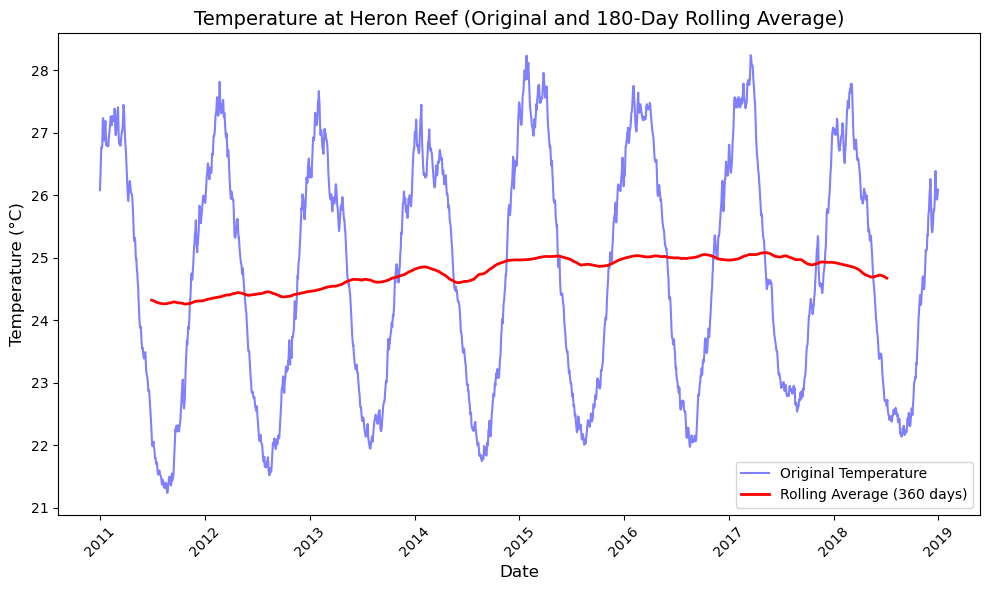

In [31]:
######################################
# TODO check if wanna do rolling, show trend in line graph
temperature_rolling2 = temperature_heatmap.rolling(time=360, center=True).mean()
df4 = pd.DataFrame({
    'date': pd.to_datetime(temperature.time.values),
    # 'lat': temperature.latitude.values,
    # 'lon': temperature.longitude.values,
    'temperature': temperature_heatmap.values,
    'temperatureRolling': temperature_rolling2.values
})
# Create line graph for temperature and rolling temperature

# Plotting the temperature and rolling temperature over time
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original temperature data
ax.plot(df4['date'], df4['temperature'], label='Original Temperature', color='blue', alpha=0.5)

# Plot rolling average temperature data
ax.plot(df4['date'], df4['temperatureRolling'], label='Rolling Average (360 days)', color='red', linewidth=2)

# Set title and labels
ax.set_title("Temperature at Heron Reef (Original and 180-Day Rolling Average)", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend to distinguish between original and rolling average
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [24]:
#TODO add different reefs location
reef_lat = -23.4
reef_lon = 151.6
reef_lat1 = -23.5
reef_lon1 = 152.0

min_lon = 151    # lower left longitude
min_lat = -24     # lower left latitude
max_lon = 153     # upper right longitude
max_lat = -22.35     # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# Performing the reduction
# ds_bio_clip = ds_bio.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
ds_hydro_clip = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))

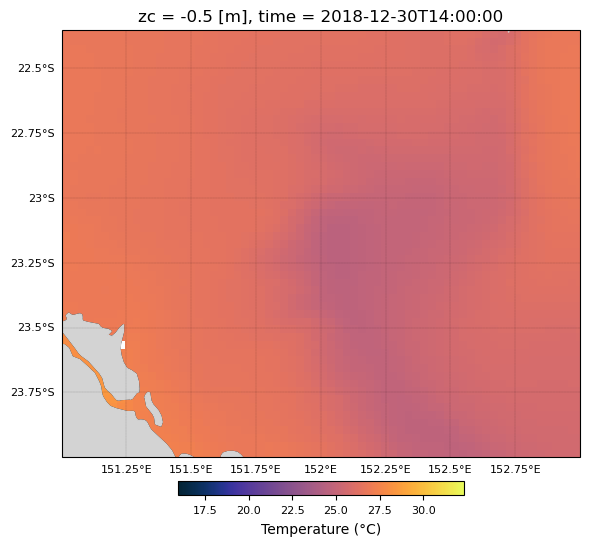

<Figure size 640x480 with 0 Axes>

In [25]:
size = (6, 6)

color = cmocean.cm.thermal

fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Use xarray's plot method for the temperature dataset
cf = ds_hydro_clip.temp.isel(time=-1, k=selectedDepthIndex).plot(
    ax=ax,  # assign the ax to the plot
    transform=ccrs.PlateCarree(),  # transform to PlateCarree projection
    cmap=color,  # use thermal colormap
    vmin=temperature.min().values,  # minimum value for colorbar (optional)
    vmax=temperature.max().values,  # maximum value for colorbar (optional)
    add_colorbar=False  # We'll add a colorbar separately
)

# Add colorbar to the plot
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, orientation="horizontal")
cbar.set_label('Temperature (°C)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Add gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=1, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# Add land feature
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))

# Display the plot
plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

Line Graphs

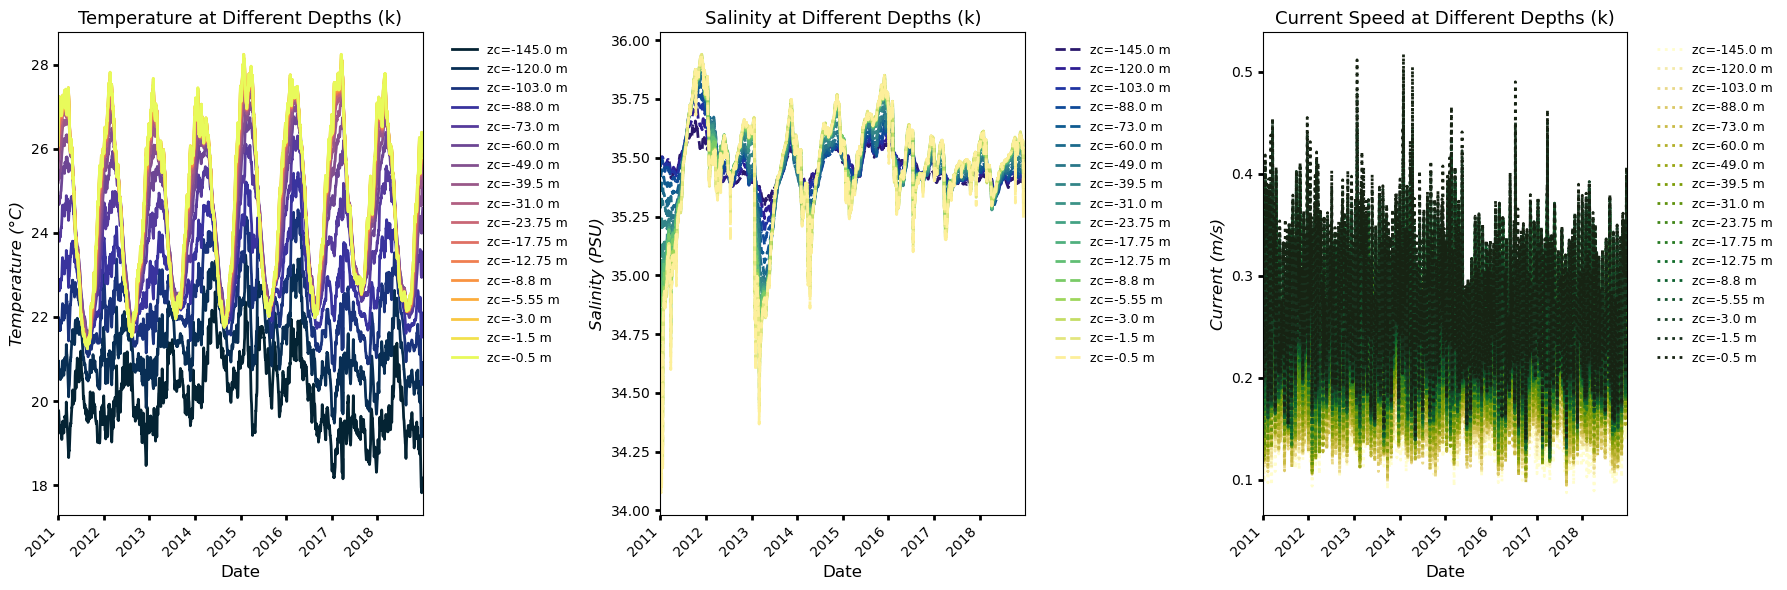

In [26]:
temperature_line = load_temp.mean(dim=['latitude', 'longitude'])
salinity_line = load_sal.mean(dim=['latitude', 'longitude'])
current_line = load_curr.mean(dim=['latitude', 'longitude'])

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

n = load_temp.zc.shape[0]  # Number of total depth levels

# Define colormaps for each variable
temp_colors = cmocean.cm.thermal(np.linspace(0, 1, n))  # Colormap for temperature
sal_colors = cmocean.cm.haline(np.linspace(0, 1, n))    # Colormap for salinity
curr_colors = cmocean.cm.speed(np.linspace(0, 1, n))    # Colormap for current

# Plot temperature, salinity, and current for each depth (k)
for zc in range(n):
    temperature_line.isel(k=zc).plot(ax=axs[0], lw=2, color=temp_colors[zc], label=f'zc={load_curr.zc.item(zc)} m')
    salinity_line.isel(k=zc).plot(ax=axs[1], lw=2, color=sal_colors[zc], linestyle='--', label=f'zc={load_curr.zc.item(zc)} m')
    current_line.isel(k=zc).plot(ax=axs[2], lw=2, color=curr_colors[zc], linestyle=':', label=f'zc={load_curr.zc.item(zc)} m')

# Loop over subplots to set labels, limits, and formatting
for i in range(3):
    axs[i].set_xlabel('Date', fontsize=12)
    axs[i].tick_params(labelcolor="k", labelsize="medium", width=2)
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, frameon=False)
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels to avoid overlap


# Set titles, y-axis, x-axis
axs[0].set_title('Temperature at Different Depths (k)', fontsize=13)
axs[0].set_ylabel('Temperature (°C)', style="italic", fontsize=12)
axs[0].set_xlim(min(load_temp.time.values), max(load_temp.time.values))

axs[1].set_title('Salinity at Different Depths (k)', fontsize=13)
axs[1].set_ylabel('Salinity (PSU)', style="italic", fontsize=12)
axs[1].set_xlim(min(load_sal.time.values), max(load_sal.time.values))

axs[2].set_title('Current Speed at Different Depths (k)', fontsize=13)
axs[2].set_ylabel('Current (m/s)', style="italic", fontsize=12)
axs[2].set_xlim(min(load_curr.time.values), max(load_curr.time.values))

# Show plot
plt.tight_layout()
plt.show()
